In [1]:
import math
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import cv2
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from snake_game import SnakeGame

In [2]:
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Starts game 
env = SnakeGame(width=30, height=30, border=1, grass_growth=0.001, max_grass=0.005)

In [4]:
# Memory buffer
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [5]:
# Transform the actions from [-1,0,1] to [0,1,2] to be used by the policy
def transform_action(action):
    return action + 1

def normalize_action(action):
    return action - 1

In [6]:
# CNN
class DQN(nn.Module):
    def __init__(self, n_observations, action_space):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=8, stride=4) 
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 3 * 3, 512) 
        self.fc2 = nn.Linear(512, action_space)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.reshape(x.size(0), -1) 
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [7]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 512
GAMMA = 0.99
EPS_START = 0.8
EPS_END = 0.4
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-2

# Get number of actions from Snake game
n_actions = 3
# Get the number of state observations
state, _, _, _ = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0

def select_action(state, exploration="eDecayGreedy"):
    global steps_done
    sample = random.random()

    # Exploration implementation
    if exploration == "eDecayGreedy":
        #Exponential decay
        eps_threshold = EPS_END + (EPS_START - EPS_END) * \
            math.exp(-1. * steps_done / EPS_DECAY)
           
    elif exploration == "lDecayGreedy":
        #Linear decay
        eps_threshold = max(EPS_END, EPS_START - (EPS_START - EPS_END) * (steps_done / EPS_DECAY))

    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            action = policy_net(state).max(1).indices.view(1, 1)
            return action
    else:
        action = torch.tensor([[env.heuristic_step()]], device=device, dtype=torch.long)
        return transform_action(action)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

episode_scores = []

def plot_scores(show_result=False):
    plt.figure(1)
    scores_t = torch.tensor(episode_scores, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.plot(scores_t.numpy())
    # Take 100 episode averages and plot them too
    if len(scores_t) >= 100:
        means = scores_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [8]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    #print("Loss: ", loss, " Rewards this batch: ", reward_batch)
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

Complete


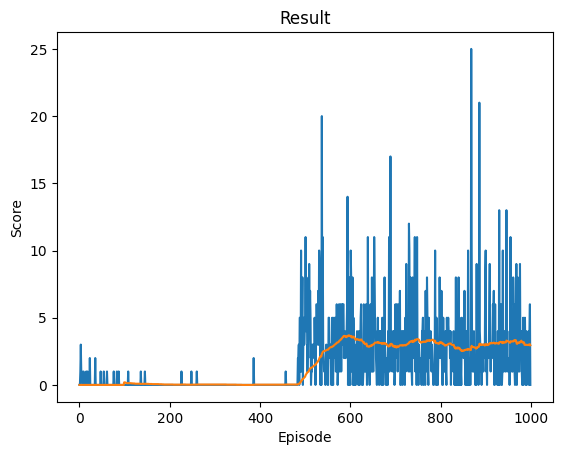

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [9]:
if torch.cuda.is_available():
    num_episodes = 1000
else:
    num_episodes = 50
    
sanity_board_check = []
sanity_actions_check = []

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, _, _, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    state = state.permute(0, 3, 1, 2)  # Change to channel-first format for Conv2D

    #Sanity check
    episode_board = []

    for t in count():
        action = select_action(state)
        observation, reward, terminated, score = env.step(normalize_action(action))
        #print("Observation shape: ", observation.shape, " Rewards: ", reward)
        reward = torch.tensor([reward], device=device)
        done = terminated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
            next_state = next_state.permute(0, 3, 1, 2)  # Change to channel-first format

        # Store the transition in memory
        if reward >= 1 or reward <= 0:
            memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        #REMOVE LATER
        episode_board.append(observation)

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            episode_scores.append(int(score["score"]))
            #REMOVE LATER
            if int(score["score"]) >= 15 :
                print("saved")
                sanity_board_check = episode_board
            #plot_durations()
            plot_scores()
            break

print('Complete')
#plot_durations(show_result=True)
plot_scores(show_result=True)
plt.ioff()
plt.show()

In [10]:
# Save the policy_net model
torch.save(policy_net.state_dict(), 'policy/dqn_policy.pth')

# Save the target_net model
torch.save(target_net.state_dict(), 'target/dqn_target.pth')

print("Models saved successfully.")

Models saved successfully.


### Different Exploration

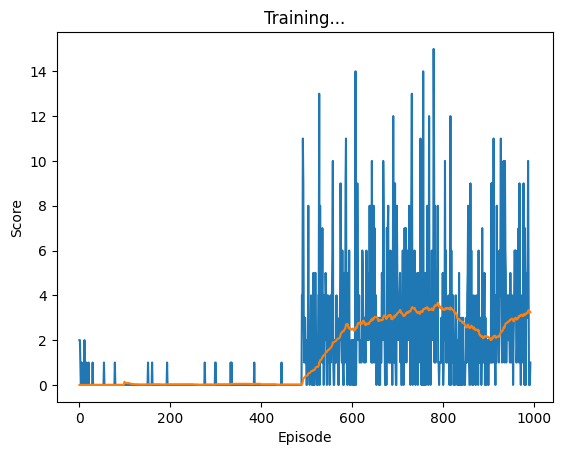

<Figure size 640x480 with 0 Axes>

In [9]:
if torch.cuda.is_available():
    num_episodes = 1000
else:
    num_episodes = 50
    
sanity_board_check = []
sanity_actions_check = []

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, _, _, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    state = state.permute(0, 3, 1, 2)  # Change to channel-first format for Conv2D

    #Sanity check
    episode_board = []

    for t in count():
        action = select_action(state, exploration="lDecayGreedy")
        observation, reward, terminated, score = env.step(normalize_action(action))
        #print("Observation shape: ", observation.shape, " Rewards: ", reward)
        reward = torch.tensor([reward], device=device)
        done = terminated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
            next_state = next_state.permute(0, 3, 1, 2)  # Change to channel-first format

        # Store the transition in memory
        if reward >= 1 or reward <= 0:
            memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        #REMOVE LATER
        episode_board.append(observation)

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            episode_scores.append(int(score["score"]))
            #REMOVE LATER
            if int(score["score"]) >= 15 :
                print("saved")
                sanity_board_check = episode_board
            #plot_durations()
            plot_scores()
            break

print('Complete')
#plot_durations(show_result=True)
plot_scores(show_result=True)
plt.ioff()
plt.show()

In [ ]:
# Save the policy_net model
torch.save(policy_net.state_dict(), 'policy/dqn_policy_el.pth')

# Save the target_net model
torch.save(target_net.state_dict(), 'target/dqn_target_el.pth')

print("Models saved successfully.")

### DQN without anything

In [8]:
def optimize_model_no_memory(state, action, next_state, reward, done):
    
    # Unsqueeze tensors to add batch dimension
    state = state  # [batch_size=1, channels, height, width]
    action = action.view(1, 1)  # [batch_size=1, 1]
    reward = reward.view(1, 1)  # [batch_size=1, 1]
    
    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state).gather(1, action)

    # Compute V(s_{t+1}) for the next state.
    # Expected values of actions for next_state are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    next_state_values = torch.zeros(1, device=device)
    if next_state is not None and not done:
        with torch.no_grad():
            next_state_values = target_net(next_state).max(1).values

    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

Complete


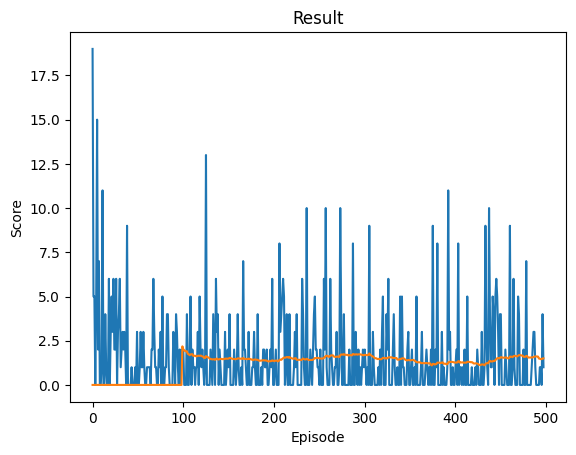

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [10]:
if torch.cuda.is_available():
    num_episodes = 1000
else:
    num_episodes = 50
    
sanity_board_check = []
sanity_actions_check = []

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, _, _, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    state = state.permute(0, 3, 1, 2)  # Change to channel-first format for Conv2D

    #Sanity check
    episode_board = []

    for t in count():
        action = select_action(state)
        observation, reward, terminated, score = env.step(normalize_action(action))
        #print("Observation shape: ", observation.shape, " Rewards: ", reward)
        reward = torch.tensor([reward], device=device)
        done = terminated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
            next_state = next_state.permute(0, 3, 1, 2)  # Change to channel-first format

        # Store the transition in memory
        if reward >= 1 or reward <= 0:
            memory.push(state, action, next_state, reward)

        # optimization
        optimize_model_no_memory(state, action, next_state, reward, done)

        # Move to the next state
        state = next_state

        #REMOVE LATER
        episode_board.append(observation)

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        # target_net_state_dict = target_net.state_dict()
        # policy_net_state_dict = policy_net.state_dict()
        # for key in policy_net_state_dict:
        #     target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        # target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            episode_scores.append(int(score["score"]))
            #REMOVE LATER
            if int(score["score"]) >= 15 :
                print("saved")
                sanity_board_check = episode_board
            #plot_durations()
            plot_scores()
            break

print('Complete')
plot_scores(show_result=True)
plt.ioff()
plt.show()

### DQN with ER

Complete


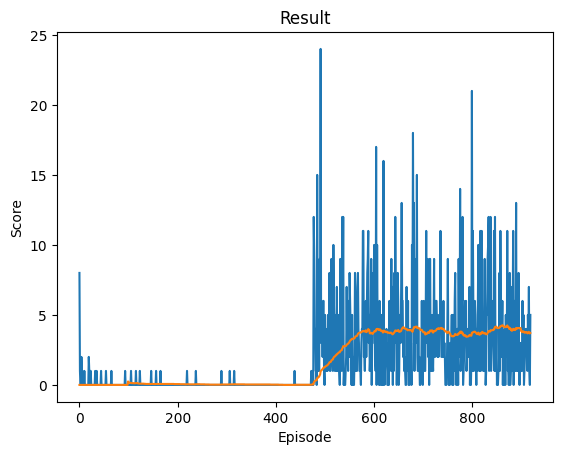

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [10]:
if torch.cuda.is_available():
    num_episodes = 1000
else:
    num_episodes = 50
    
sanity_board_check = []
sanity_actions_check = []

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, _, _, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    state = state.permute(0, 3, 1, 2)  # Change to channel-first format for Conv2D

    #Sanity check
    episode_board = []

    for t in count():
        action = select_action(state)
        observation, reward, terminated, score = env.step(normalize_action(action))
        #print("Observation shape: ", observation.shape, " Rewards: ", reward)
        reward = torch.tensor([reward], device=device)
        done = terminated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
            next_state = next_state.permute(0, 3, 1, 2)  # Change to channel-first format

        # Store the transition in memory
        if reward >= 1 or reward <= 0:
            memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        #REMOVE LATER
        episode_board.append(observation)

        # Remove optimization
        optimize_model()

        if done:
            episode_durations.append(t + 1)
            episode_scores.append(int(score["score"]))
            #REMOVE LATER
            if int(score["score"]) >= 15 :
                print("saved")
                sanity_board_check = episode_board
            #plot_durations()
            plot_scores()
            break

print('Complete')
plot_scores(show_result=True)
plt.ioff()
plt.show()


### DQN with TN

Complete


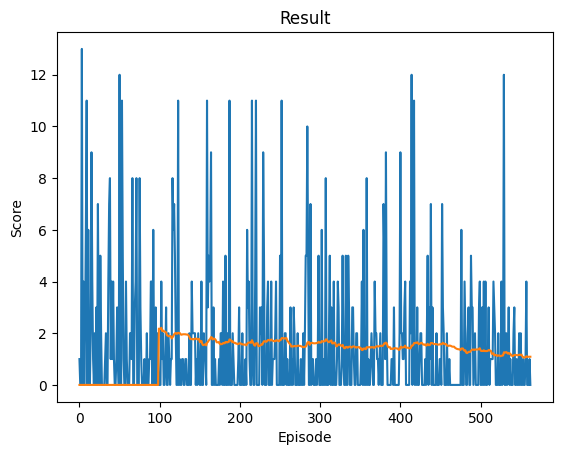

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [12]:
if torch.cuda.is_available():
    num_episodes = 1000
else:
    num_episodes = 50
    
sanity_board_check = []
sanity_actions_check = []

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, _, _, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    state = state.permute(0, 3, 1, 2)  # Change to channel-first format for Conv2D

    #Sanity check
    episode_board = []

    for t in count():
        action = select_action(state)
        observation, reward, terminated, score = env.step(normalize_action(action))
        #print("Observation shape: ", observation.shape, " Rewards: ", reward)
        reward = torch.tensor([reward], device=device)
        done = terminated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
            next_state = next_state.permute(0, 3, 1, 2)  # Change to channel-first format

        # Store the transition in memory
        if reward >= 1 or reward <= 0:
            memory.push(state, action, next_state, reward)

        # optimization
        optimize_model_no_memory(state, action, next_state, reward, done)

        # Move to the next state
        state = next_state

        #REMOVE LATER
        episode_board.append(observation)

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            episode_scores.append(int(score["score"]))
            #REMOVE LATER
            if int(score["score"]) >= 15 :
                print("saved")
                sanity_board_check = episode_board
            #plot_durations()
            plot_scores()
            break

print('Complete')
plot_scores(show_result=True)
plt.ioff()
plt.show()

In [ ]:
images = sanity_board_check
# Define the update function for the animation
def update(frame):
    plt.clf()  # Clear the current frame
    plt.imshow(images[frame])  # Display the current image
    plt.axis('off')  # Hide the axes for a cleaner look

fig = plt.figure()

# Create the animation
ani = FuncAnimation(fig, update, frames=len(images[1:]), interval=50, repeat=True)

# Display the animation in Jupyter Notebook
HTML(ani.to_jshtml())